# Gekachelte Bildverarbeitung, ein schneller Durchlauf

In diesem Notebook werden wir einen großen Datensatz verarbeiten, der im zarr-Format gespeichert wurde, um Zellen in einzelnen Kacheln mit Hilfe von [dask](https://docs.dask.org/en/stable/) und [zarr](https://zarr.readthedocs.io/en/stable/) zu zählen. Die zugrunde liegenden Prinzipien werden in den nächsten Abschnitten erklärt.

In [1]:
import zarr
import dask.array as da
import numpy as np
from skimage.io import imread
import pyclesperanto_prototype as cle
from pyclesperanto_prototype import imshow
from numcodecs import Blosc

Zu Demonstrationszwecken verwenden wir einen Datensatz, der von Theresa Suckert, OncoRay, Universitätsklinikum Carl Gustav Carus, TU Dresden, zur Verfügung gestellt wurde. Der Datensatz ist unter der [Lizenz: CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/) lizenziert. Wir verwenden hier eine zugeschnittene Version, die als 8-Bit-Bild neu gespeichert wurde, um sie mit dem Notebook bereitstellen zu können. Das vollständige 16-Bit-Bild im CZI-Dateiformat finden Sie [online](https://zenodo.org/record/4276076#.YX1F-55BxaQ). Der biologische Hintergrund wird in [Suckert et al. 2020](https://www.sciencedirect.com/science/article/abs/pii/S0167814020301043) erklärt, wo wir auch einen ähnlichen Workflow angewendet haben. 

Wenn Sie mit großen Datenmengen arbeiten, werden Sie wahrscheinlich bereits ein Bild im richtigen Format vorliegen haben. Zu Demonstrationszwecken speichern wir hier ein Testbild im zarr-Format, das häufig zur Verarbeitung großer Bilddaten verwendet wird.

In [2]:
# Resave a test image into tiled zarr format
input_filename = '../../data/P1_H_C3H_M004_17-cropped.tif'
zarr_filename = '../../data/P1_H_C3H_M004_17-cropped.zarr'
image = imread(input_filename)[1]
compressor = Blosc(cname='zstd', clevel=3, shuffle=Blosc.BITSHUFFLE)
zarray = zarr.array(image, chunks=(100, 100), compressor=compressor)
zarr.convenience.save(zarr_filename, zarray)

## Laden des zarr-gestützten Bildes
Dask bietet integrierte Unterstützung für das zarr-Dateiformat. Wir können dask-Arrays direkt aus einer zarr-Datei erstellen.

In [3]:
zarr_image = da.from_zarr(zarr_filename)
zarr_image

dask.array<from-zarr, shape=(2000, 5000), dtype=uint8, chunksize=(100, 100), chunktype=numpy.ndarray>

Wir können die Bildverarbeitung direkt auf diesen gekachelten Datensatz anwenden.

## Zählen von Zellkernen
Zum Zählen der Zellkerne erstellen wir einen einfachen Bildverarbeitungsworkflow. Er gibt ein Bild zurück, das einen einzelnen Pixel enthält, der die Anzahl der Zellkerne im gegebenen Eingabebild angibt. Diese einzelnen Pixel werden zu einer Pixelzählkarte zusammengesetzt; ein Bild mit viel weniger Pixeln als das Originalbild, aber mit dem Vorteil, dass wir es anschauen können - es sind keine großen Daten mehr.cle.exclude_labels_with_map_values_within_range

In [4]:
def count_nuclei(image):
    """
    Label objects in a binary image and produce a pixel-count-map image.
    """
    # Count nuclei including those which touch the image border
    labels = cle.voronoi_otsu_labeling(image, spot_sigma=3.5)
    label_intensity_map = cle.mean_intensity_map(image, labels)
    
    high_intensity_labels = cle.exclude_labels_with_map_values_within_range(label_intensity_map, labels, maximum_value_range=20)
    nuclei_count = high_intensity_labels.max()
    
    # Count nuclei including those which touch the image border
    labels_without_borders = cle.exclude_labels_on_edges(high_intensity_labels)
    nuclei_count_excluding_borders = labels_without_borders.max()
    
    # Both nuclei-count including and excluding nuclei at image borders 
    # are no good approximation. We should exclude the nuclei only on 
    # half of the borders to get a good estimate.
    # Alternatively, we just take the average of both counts.
    result = np.asarray([[(nuclei_count + nuclei_count_excluding_borders) / 2]])
    
    return result

Bevor wir mit der Berechnung beginnen können, müssen wir die asynchrone Ausführung von Operationen in pyclesperanto deaktivieren. [Siehe auch zugehöriges Problem](https://github.com/clEsperanto/pyclesperanto_prototype/issues/163).

In [5]:
cle.set_wait_for_kernel_finish(True)

Für die Verarbeitung von Kacheln mit dask richten wir Verarbeitungsblöcke ohne Überlappung ein.

In [6]:
tile_map = da.map_blocks(count_nuclei, zarr_image)

tile_map

dask.array<count_nuclei, shape=(2000, 5000), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>

Da das Ergebnisbild viel kleiner ist als das Original, können wir die gesamte Ergebniskarte berechnen.

In [7]:
result = tile_map.compute()

In [8]:
result.shape

(20, 50)

Da die Ergebniskarte klein ist, können wir sie einfach visualisieren.

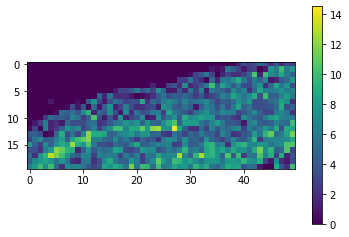

In [9]:
cle.imshow(result, colorbar=True)

Mit einer schnellen visuellen Überprüfung im Originalbild können wir sehen, dass in der oberen linken Ecke des Bildes tatsächlich viel weniger Zellen sind als in der unteren rechten Ecke.

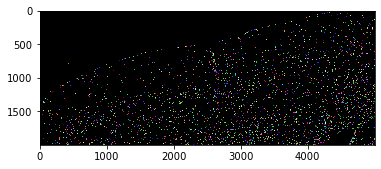

In [10]:
cle.imshow(cle.voronoi_otsu_labeling(image, spot_sigma=3.5), labels=True)